In [1]:
from argparse import Namespace
import os
import json
from collections import Counter
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions

In [2]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [3]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [4]:
class TweetVectorizer(object):
    def __init__(self, tweet_vocab, sentiment_vocab, max_sequence_length):
        self.tweet_vocab = tweet_vocab
        self.sentiment_vocab = sentiment_vocab
        self.max_sequence_length = max_sequence_length

    def vectorize(self, tweet, vector_length=-1):
        """
        Args:
            tweet (str): the string of words
            vector_length (int): an argument for forcing the length of index vector
        """
        indices = [self.tweet_vocab.begin_seq_index]  # Start with <BEGIN>

        for token in tweet.lower().split(" "):  
            if token not in string.punctuation:  
                indices.append(self.tweet_vocab.lookup_token(token))  # Map token to index

        indices.append(self.tweet_vocab.end_seq_index)  # End with <END>

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)         
        out_vector[:len(indices)] = indices  # Fill with token indices
        out_vector[len(indices):] = self.tweet_vocab.mask_index  # Padding with <MASK>
        
        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, tweet_df, cutoff=2):
        """Instantiate the vectorizer from the dataset dataframe"""
        tweet_vocab = SequenceVocabulary()
        sentiment_vocab = Vocabulary()
        
        max_sequence_length = 0

        # Add sentiments
        for sentiment in sorted(set(tweet_df.label)):
            sentiment_vocab.add_token(sentiment)

        # Add top words if count > provided cutoff
        word_counts = Counter()
        for tweet in tweet_df.processed_text:  # Use `processed_text` for vectorization
            tokens = tweet.lower().split(" ")  
            if len(tokens) > max_sequence_length:
                max_sequence_length = len(tokens)
            for word in tokens:
                if word not in string.punctuation:  
                    word_counts[word] += 1

        for word, count in word_counts.items():
            if count > cutoff:
                tweet_vocab.add_token(word)

        return cls(tweet_vocab, sentiment_vocab, max_sequence_length)


In [5]:
class TweetDataset(Dataset):
    def __init__(self, tweet_df, vectorizer):
        """
        Args:
            tweet_df (pandas.DataFrame): the dataset
            vectorizer (TweetVectorizer): vectorizer instantiated from dataset
        """
        self.tweet_df = tweet_df
        self._vectorizer = vectorizer

        # Max sequence length including special tokens
        measure_len = lambda tweet: len(tweet.split(" "))
        self._max_seq_length = max(map(measure_len, tweet_df.processed_text)) + 2  # <BEGIN> and <END>

        self.train_df = self.tweet_df[self.tweet_df.split == 'train']
        self.train_size = len(self.train_df)

        self.val_df = self.tweet_df[self.tweet_df.split == 'val']
        self.validation_size = len(self.val_df)

        self.test_df = self.tweet_df[self.tweet_df.split == 'test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # Class weights
        class_counts = self.train_df.label.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.sentiment_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, tweet_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            tweet_csv (str): location of the dataset
        Returns:
            an instance of TweetDataset
        """
        tweet_df = pd.read_csv(tweet_csv)
        train_tweet_df = tweet_df[tweet_df.split == 'train']
        return cls(tweet_df, TweetVectorizer.from_dataframe(train_tweet_df))
        
    def get_vectorizer(self):
        """Returns the vectorizer."""
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """The primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]
        
        tweet_vector, vec_length = \
            self._vectorizer.vectorize(row.processed_text, self._max_seq_length)
        
        sentiment_index = \
            self._vectorizer.sentiment_vocab.lookup_token(row.label)

        return {'x_data': tweet_vector,
                'y_target': sentiment_index,
                'x_length': vec_length}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size


def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=False, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the right device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict


In [6]:

def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)

def column_summation(y_out, x_lengths, mode="mean"):
    '''Get a max or mean vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the max or mean vector of all the vectors by 
    the position indicated by the corresponding value in `x_lengths` at the row index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)
        mode: "mean" for mean vector; "max" for max vector

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        if mode == "mean":
            out.append(y_out[batch_index, 0:column_index+1].mean(dim=0))  # get the mean vector
        else:
            out.append(y_out[batch_index, 0:column_index+1].max(dim=0).values)  # get the max vector

    return torch.stack(out)

class TweetClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, bidirectional=False, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_size (int): The size of the word embeddings
            num_embeddings (int): The number of words to embed
            num_classes (int): The size of the prediction vector 
                Note: the number of sentiment classes
            bidirectional (bool): Whether to use a bidirectional RNN
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Whether input tensors have batch first or sequence first
            padding_idx (int): The index for tensor padding; see torch.nn.Embedding
        """
        super(TweetClassifier, self).__init__()

        self.num_directions = 2 if bidirectional else 1
        
        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)

        self.rnn = nn.RNN(input_size=embedding_size,
                          hidden_size=rnn_hidden_size,
                          batch_first=batch_first, 
                          num_layers=1,
                          dropout=0.0, 
                          bidirectional=bidirectional)

        self.fc2 = nn.Linear(in_features=rnn_hidden_size * self.num_directions,
                             out_features=num_classes)
        self.bn1 = nn.BatchNorm1d(rnn_hidden_size * self.num_directions) 

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """
        The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): Input tensor (batch, input_dim)
            x_lengths (torch.Tensor): Lengths of each sequence in the batch
                Used to extract the final vector of each sequence
            apply_softmax (bool): Whether to apply softmax to the output
        Returns:
            Tensor with shape (batch, output_dim)
        """
        x_embedded = self.emb(x_in)  # x_embedded: (batch, seq_size, feat_size)
               
        y_out, _ = self.rnn(x_embedded)        
        
        if x_lengths is not None:
             y_out = column_gather(y_out, x_lengths)  # Gather the final hidden vector for each sequence
        else:
             y_out = y_out[:, -1, :]

        # Linear layer for classification
        y_out = self.fc2(y_out)

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out


In [7]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [8]:
args = Namespace(
    # Data and path information
    tweet_csv="data_preprocess.csv",  
    model_state_file="model.pth",  
    save_dir="model_storage/tweet_classification",  
    # Model hyperparameters
    word_embedding_size=100,  
    rnn_hidden_size=256, 
    bidirectional=False,  
    # Training hyperparameters
    num_epochs=100, 
    learning_rate=2e-3,  
    batch_size=128,  
    seed=1337,  
    early_stopping_criteria=5,  
    # Runtime hyperparameters
    cuda=True, 
    catch_keyboard_interrupt=True,  
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,  
)

if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

set_seed_everywhere(args.seed, args.cuda)

handle_dirs(args.save_dir)

Using CUDA: False


In [9]:
dataset = TweetDataset.load_dataset_and_make_vectorizer(args.tweet_csv)

vectorizer = dataset.get_vectorizer()

classifier = TweetClassifier(embedding_size=args.word_embedding_size, 
                              num_embeddings=len(vectorizer.tweet_vocab),
                              num_classes=len(vectorizer.sentiment_vocab),
                              rnn_hidden_size=args.rnn_hidden_size,
                              padding_idx=vectorizer.tweet_vocab.mask_index,
                              bidirectional=args.bidirectional)


In [10]:
len(vectorizer.tweet_vocab)

12010

In [11]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [12]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=10)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()
           
            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/249 [00:00<?, ?it/s]

split=val:   0%|          | 0/53 [00:00<?, ?it/s]

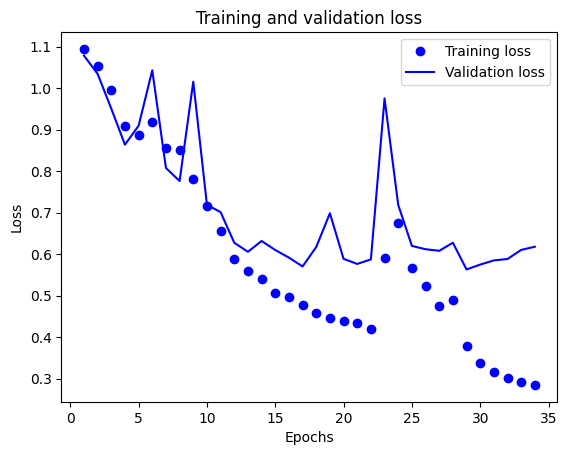

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

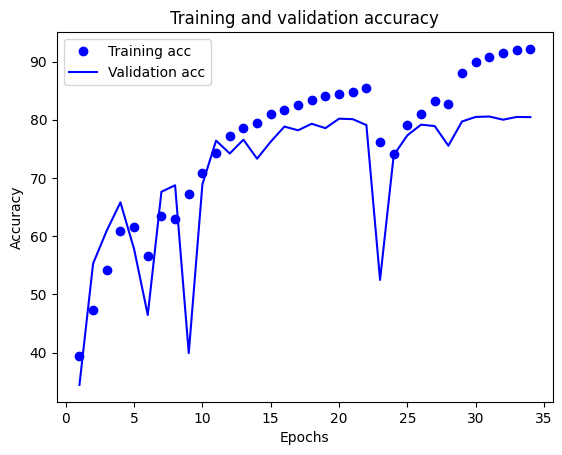

In [14]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [15]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename'],weights_only=False))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

y_pred_list = []         # store predicted values for confusion matrix
y_rating_list = []  # ground truth value

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],
                         x_lengths=batch_dict['x_length'])

    # store predicted values and ground truth values for calculating confusion matrix
    y_pred_list.extend(y_pred.max(dim=1)[1].cpu().numpy())
    y_rating_list.extend(batch_dict['y_target'].cpu().numpy())
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.6021280376999467;
Test Accuracy: 78.35905790208018


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
sentiment_classes = []
for i in range(len(dataset._vectorizer.sentiment_vocab)):
    sentiment_classes.append(dataset._vectorizer.sentiment_vocab.lookup_index(i))
print(sentiment_classes)

['negative', 'neutral', 'positive']


In [17]:
import pandas as pd
cm = confusion_matrix(y_rating_list, y_pred_list)  
cm_df = pd.DataFrame(cm.T, index=sentiment_classes, columns=sentiment_classes)  
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)


True       negative  neutral  positive
Predicted                             
negative       1809      179        78
neutral         428     1120       522
positive         64      209      2448


In [18]:
print(classification_report(y_rating_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      2301
           1       0.54      0.74      0.63      1508
           2       0.90      0.80      0.85      3048

    accuracy                           0.78      6857
   macro avg       0.77      0.78      0.77      6857
weighted avg       0.81      0.78      0.79      6857



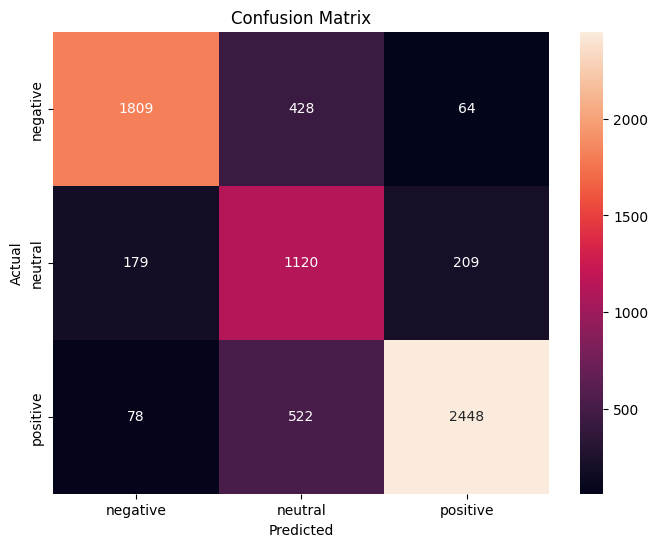

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = list(vectorizer.sentiment_vocab._idx_to_token.values())  #

conf_matrix = confusion_matrix(y_rating_list, y_pred_list)  

plt.figure(figsize=(8, 6)) 
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)  
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
